# Sorting Fixed Sized Arrays with Encoder Decoder LSTMs

Here we generate random fixed sized arrays and their sorted versions, then we train a encoder-decoder lstm . 

Based on https://github.com/ematvey/tensorflow-seq2seq-tutorials/blob/master/1-seq2seq.ipynb


In [1]:
###############################################
#               CREATE DATASET                #
###############################################

import random
import numpy as np
import pickle


In [166]:
n_size=8
min_num=0
max_num=9
n_samples=1000

print_step=10000

X=[]
Y=[]

for i in range(n_samples):
    k=[]
    for j in range(n_size):
        s=random.randint(min_num,max_num)
        k.append(s)
    k=np.array(k)
    Y.append(np.array(sorted(k)))
    X.append(np.array(k))
    
    if(i%print_step==0):
        print(i,'Done')
    
X=np.array(X).T
Y=np.array(Y).T

data={}
data['X']=X
data['Y']=Y

with open('data/sort_data.data','wb') as f:
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)



0 Done


In [167]:
def get_next_batch(X,Y,idx,batch_size=200):
    return X[:,idx*batch_size:(idx+1)*batch_size],np.ones((n_size,batch_size)),Y[:,idx*batch_size:(idx+1)*batch_size]

In [189]:
import numpy as np
import tensorflow as tf

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [190]:
## define model params

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 10
decoder_hidden_units = encoder_hidden_units


In [191]:
#setting encoder and decoder inputs and decoder traget


encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')

In [192]:
## define embedding matrix

embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)


encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

In [193]:
## Encoder cell

encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_inputs_embedded,
    dtype=tf.float32, time_major=True,
)

del encoder_outputs

In [194]:
## Decoder cell

decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)

decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    decoder_cell, decoder_inputs_embedded,

    initial_state=encoder_final_state,

    dtype=tf.float32, time_major=True, scope="plain_decoder",
)

In [195]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)

decoder_prediction = tf.argmax(decoder_logits, 2)


## Optimizer and loss defination
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)


In [196]:
sess.run(tf.global_variables_initializer())


In [197]:
## test forward pass
enc_x,dec_x,y=get_next_batch(X,Y,0)
pred=sess.run(decoder_prediction,feed_dict={encoder_inputs:enc_x,decoder_inputs:dec_x})
pred

array([[0, 9, 7, ..., 7, 8, 7],
       [0, 9, 0, ..., 9, 0, 7],
       [0, 9, 0, ..., 0, 0, 1],
       ..., 
       [0, 0, 0, ..., 1, 0, 1],
       [1, 1, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [198]:
## train model

batch_size=200
num_batches=int(X.shape[1]/batch_size)
n_epochs=1000
print_batch=50
loss_track=[]

for i in range(n_epochs):
    for j in range(num_batches):
        enc_x,dec_x,y=get_next_batch(X,Y,j)
        #print(enc_x.shape,dec_x.shape,y.shape)
        sess.run(train_op,feed_dict={encoder_inputs:enc_x,decoder_targets:y,decoder_inputs:dec_x})
    l=sess.run(loss,feed_dict={encoder_inputs:enc_x,decoder_targets:y,decoder_inputs:dec_x})
    loss_track.append(l)
    if(i%print_batch==0):
        print('EPoch',i,'Loss',l)


EPoch 0 Loss 2.3402
EPoch 50 Loss 1.10886
EPoch 100 Loss 0.715226
EPoch 150 Loss 0.507615
EPoch 200 Loss 0.393419
EPoch 250 Loss 0.321735
EPoch 300 Loss 0.269783
EPoch 350 Loss 0.219873
EPoch 400 Loss 0.160317
EPoch 450 Loss 0.119732
EPoch 500 Loss 0.0943859
EPoch 550 Loss 0.0757743
EPoch 600 Loss 0.0617971
EPoch 650 Loss 0.0509758
EPoch 700 Loss 0.0425261
EPoch 750 Loss 0.0358582
EPoch 800 Loss 0.0305088
EPoch 850 Loss 0.0261453
EPoch 900 Loss 0.0225305
EPoch 950 Loss 0.0194943


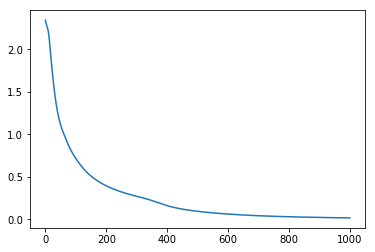

In [199]:
from matplotlib import pyplot as plt

plt.plot(loss_track)
plt.show()

In [200]:
def predict(X):
    enc_x=X.T
    dec_x=np.ones((n_size,enc_x.shape[1]))
    pred=sess.run(decoder_prediction,feed_dict={encoder_inputs:enc_x,decoder_inputs:dec_x})
    print(X,pred.T)

In [205]:
l=np.array([[9,0,1,0,1,0,1,9]])
l.shape
predict(l)

[[9 0 1 0 1 0 1 9]] [[0 0 0 1 1 1 9 9]]
